In [65]:
%matplotlib inline

In [66]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import linregress
from scipy.signal import convolve2d, gaussian, argrelextrema
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import pickle
import librosa
import glob
import re
import sys
import os
import mido
from mido import MidiFile

### Load strips

All pkl data lies in this directory

In [67]:
pkl_dir = 'score_data/pkl_data'

In [68]:
def sort_nicely(l):
    d = {}
    for elem in l:
        m = re.search('\S+-(\d+)\.pkl', elem)
        if m:
            idx = int(m.group(1))
            d[idx] = elem
        else:
            print('Failed regular expression matching: %s') % (elem)
            sys.exit(1)
    sorted_filenames = [d[key] for key in sorted(d.keys())]
    return sorted_filenames

In [69]:
def loadStripData(basename):
    pkl_files = sort_nicely(glob.glob(pkl_dir + '/' + basename + '-*.pkl'))
    strips = []
    for pkl_file in pkl_files:
        with open(pkl_file, 'rb') as f:
            d = pickle.load(f)
            strips.extend(d['strips'])
    return strips

In [70]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [71]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

In [77]:
scoreFile = 'op30no2_v4'#Beethoven_sonata27_Op90_Clean_Movement1'

In [78]:
strips = loadStripData(scoreFile)

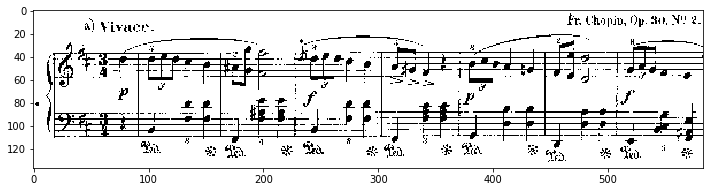

In [79]:
showImage(strips[0])

### Sheet music strip analysis

In [80]:
def locateStaffLines(s, delta = 3):
    medvals = np.median(s, axis=1)
    for i, curVal in enumerate(medvals):
        if i > delta and i < len(medvals)-delta:
            if curVal != np.max(medvals[i-delta:i+delta+1]): # only keep local maxima
                medvals[i] = 0
    idxs_sorted_val = np.argsort(medvals)[::-1]
    idxs_lines = sorted(idxs_sorted_val[0:10])
    return np.array(idxs_lines)

In [81]:
def estimateMidiNum2PixelRowMapping(s, lineIdxs, hand = 'right'):
    if hand == 'right':
        x = np.array([77, 74, 71, 67, 64]) # midi nums for staff lines
    elif hand == 'left':
        x = np.array([57, 53, 50, 47, 43])
    else:
        print('Unrecognized value for hand: %s') % hand
        sys.exit(1)
    m, b, _, _, _ = linregress(x, lineIdxs)
    return (m,b)

In [82]:
def estimatePixelRow(midinum, m, b):
    return np.int(np.round(midinum * m + b))

Estimate the location of C4 in the sheet music

In [83]:
s = strips[0]
lines = locateStaffLines(s)
breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
m, b = estimateMidiNum2PixelRowMapping(s[0:breakpt,:], lines[0:5], 'right')
estC4 = estimatePixelRow(60, m, b)

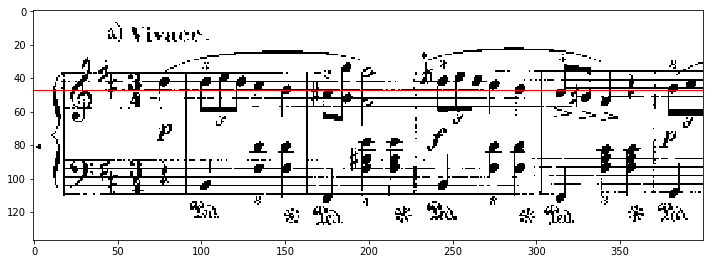

In [84]:
showImage(s[:,0:400])
plt.axhline(y = estC4, color='r', linewidth=1)
plt.show()

To prevent the system from matching notes to barlines, we suppress vertical lines

In [85]:
def suppressVerticalLines(s):
    rowStart = int(s.shape[0]*.25)
    rowEnd = int(s.shape[0]*.75) + 1
    medians = np.median(s[rowStart:rowEnd,:], axis=0)
    suppressed = np.clip(s - medians, 0, 1)
    return suppressed

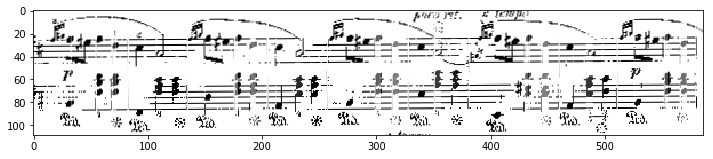

In [86]:
sup = suppressVerticalLines(strips[5])
showImage(sup)

### Synthesize sheet music from midi

In [87]:
def getMidiNoteEvents(midifile, fs = 100):
    mid = MidiFile(midifile)
    noteEvents = []
    tempo = 500000 # default microseconds per beat
    curTimeSec = 0.0
    assert(len(mid.tracks) == 1)
    for msg in mid.tracks[0]:
        curTimeSec += mido.tick2second(msg.time, mid.ticks_per_beat, tempo)
        if msg.type == 'set_tempo':
            tempo = msg.tempo
        if msg.type == 'note_on':
            colIdx = np.int(np.round(curTimeSec * fs))
            noteEvents.append((colIdx, msg.note))
        if msg.type == 'text' and '!!!END:' in msg.text: # ignore command messages that add time at end
            break            
    return noteEvents

In [88]:
def synthesizeSheetMusic(noteEvents, strip, zeroPad = 50):
    
    # analyze the strip
    lines = locateStaffLines(strip)
    breakpt = np.int(np.round(.5*(lines[4]+lines[5])))
    upper = strip[0:breakpt,:]
    lower = strip[breakpt:,:]
    m1, b1 = estimateMidiNum2PixelRowMapping(upper, lines[0:5], 'right')
    m2, b2 = estimateMidiNum2PixelRowMapping(lower, lines[5:10] - breakpt, 'left')
    
    # synthesis
    impulses1 = generateNoteImpulses(noteEvents, upper, m1, b1)
    impulses2 = generateNoteImpulses(noteEvents, lower, m2, b2)
    impulses = mergeNoteImpulses(impulses1, impulses2, noteEvents)
    timeAdjusted, timeMapping = adjustMidiTiming(impulses)
    zeroPadded = zeroPadColumns(timeAdjusted, zeroPad, zeroPad)
    filt2d = get2DFilter(np.mean([np.abs(m1),np.abs(m2)]))
    blurred = convolve2d(zeroPadded, filt2d, 'same')
    stavesTemplate = np.matlib.repmat(np.median(strip, axis=1).reshape(-1,1), 1, blurred.shape[1])
    withLines = np.clip(blurred + stavesTemplate, 0, 1)
    return withLines, timeMapping

In [89]:
def generateNoteImpulses(noteEvents, strip, m, b):
    synthLen = noteEvents[-1][0] + 1
    impulses = np.zeros((strip.shape[0], synthLen))
    for (timeIdx, midinum) in noteEvents:
        row = estimatePixelRow(midinum, m, b)
        if row >= 0 and row < strip.shape[0]:
            impulses[row, timeIdx] = 1
    return impulses

In [90]:
def mergeNoteImpulses(impulses1, impulses2, noteEvents):
    # This function double checks that whenever a note event occurs, at least one note shows up in the 
    # synthesized score (adding a redundant note if necessary).  This avoids the rare situation where a
    # note event occurs but falls outside of both strips, which leads to midi synthesized scores having
    # different lengths due to shortening of long pauses.
    merged = np.vstack((impulses1, impulses2))
    csum = np.sum(merged, axis=0)
    for (timeIdx, midiNote) in noteEvents:
        if csum[timeIdx] == 0:
            merged[0, timeIdx] = 1 # add redundant note
    return merged

In [91]:
def adjustMidiTiming(noteImpulses, maxPauseLen = 50):
    
    # identify long pauses where no onsets occur
    csums = np.sum(noteImpulses, axis=0)   
    dataToInsert = [] # either the index of the column to insert, or -1 for a column of zeros
    isPause = False
    markerStart = 0
    for i in range(len(csums)):
        if isPause:
            if csums[i] != 0 or i == len(csums) - 1: # in a pause, notes occur
                pauseLen = i - markerStart
                if pauseLen > maxPauseLen:
                    dataToInsert.extend([-1] * maxPauseLen)
                else:
                    dataToInsert.extend([-1] * pauseLen)
                dataToInsert.append(i)
                isPause = False
            else: # in a pause, no notes occur
                pass
        else:
            if csums[i] != 0: # not a pause, notes occur
                dataToInsert.append(i)
            else: # not a pause, no notes occur
                isPause = True
                markerStart = i
    
    # reconstruct onset data
    adjusted = np.zeros((noteImpulses.shape[0],len(dataToInsert)))
    for i, col in enumerate(dataToInsert):
        if col == -1:
            pass # leave as zeros
        else:
            adjusted[:,i] = noteImpulses[:,col]
    return adjusted, dataToInsert

In [92]:
def get2DFilter(m):
    filt_sz = np.int(np.round(np.abs(m) * 4))
    filt2d = getBlurFilter(filt_sz, 'block')
    return filt2d

In [93]:
def getBlurFilter(sz, filterType):
    if filterType == 'hamming':
        filt = np.matmul(np.hamming(sz).reshape((sz,1)), np.hamming(sz).reshape(1,sz))
    elif filterType == 'circle':
        filt = np.zeros((sz,sz))
        center = sz/2
        for i in range(sz):
            for j in range(sz):
                if np.sqrt((i-center)*(i-center)+(j-center)*(j-center)) <= center - .01:
                    filt[i,j] = 1
    elif filterType == 'block':
        filt = np.ones((sz,np.int(1.5*sz)))
    else:
        print('Unrecognized filter type: %s' % filterType)
        sys.exit(1)
    return filt

In [94]:
def zeroPadColumns(X, nBefore, nAfter):
    h = X.shape[0]
    Y = np.hstack((np.zeros((h,nBefore)), X, np.zeros((h,nAfter))))
    return Y

In [95]:
#midiFile = 'midi/op68no3/pid1263b-19-avgtapsd0.mid'
#midiFile = 'midi/op63no3/pid9058b-12-avgtapsd0.mid'
midiFile = 'midi/Beethoven_sonata27_Op90_Clean_Movement1/Beethoven_sonata27_Op90_Clean_Movement1.mid'
noteEvents = getMidiNoteEvents(midiFile)
midiSynth, _ = synthesizeSheetMusic(noteEvents, s)

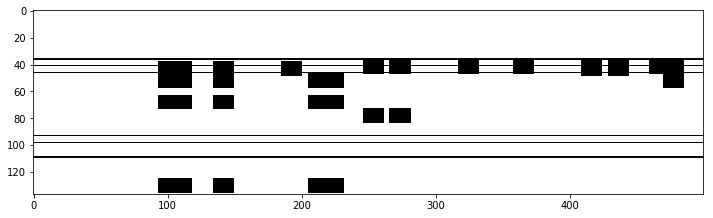

In [96]:
showImage(midiSynth[:,0:500])

### Align sequence of strips

In [97]:
def alignStripSequence(strips, midiFile, zeroPad = 50):
    
    # find optimal fs
    fs = 100.0
    noteEvents = getMidiNoteEvents(midiFile, fs)
    striplen = np.sum([s.shape[1] for s in strips])
    fs = np.int(fs * striplen / noteEvents[-1][0]) # adjust to get equal lengths
    noteEvents = getMidiNoteEvents(midiFile, fs)
    
    # fill in cost matrix block by block
    Cblocks = []
    midiSynths = []
    for i in range(len(strips)):
        s = suppressVerticalLines(strips[i])
        midiSynth, timeMapping = synthesizeSheetMusic(noteEvents, s, zeroPad)
        costBlock = -1.0 * np.matmul(s.T, midiSynth)
        Cblocks.append(costBlock)
        midiSynths.append(midiSynth)
    C = np.vstack(Cblocks)
        
    # DTW
    steps = np.array([1,1,1,2,2,1]).reshape((-1,2))
    weights = np.array([2,3,3])
    D, wp = librosa.core.dtw(C=C, step_sizes_sigma=steps, weights_mul=weights)
    
    return wp[::-1,:], midiSynths, timeMapping, fs

In [98]:
def visualizeAlignedSequences(strips, midiSynths, wp, scoreFile = None, midiFile = None):
    
    # generate panorama of sheet music strips 
    maxH = np.max([s.shape[0] for s in strips])
    pan1 = np.zeros((maxH, wp.shape[0]))
    cumStripLens = np.cumsum([0] + [s.shape[1] for s in strips])
    col2strip = [i for i, s in enumerate(strips) for j in range(s.shape[1])] # column index -> strip index
    for i in range(wp.shape[0]):
        globalIdx = wp[i,0]
        stripIdx = col2strip[globalIdx]
        h = strips[stripIdx].shape[0]
        localIdx = globalIdx - cumStripLens[stripIdx]
        pan1[0:h,i] = strips[stripIdx][:, localIdx]
        
    # generate panorama for midi synthesis
    pan2 = np.zeros((maxH, wp.shape[0]))
    for i in range(wp.shape[0]):
        sheetColIdx = wp[i,0]
        midiColIdx = wp[i,1]
        stripIdx = col2strip[sheetColIdx]
        h = strips[stripIdx].shape[0]
        pan2[0:h, i] = midiSynths[stripIdx][:,midiColIdx]

    stacked = np.vstack((pan1, pan2))
    
    # overlay score beat annotations
    if scoreFile:
        with open('gt.pkl', 'rb') as f: # e.g. op68no3_v3
            d = pickle.load(f) 
        scoreRefBeats = d[scoreFile]
        xcoords = np.interp(scoreRefBeats, wp[:,0], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[0:maxH,np.int(np.round(x))] = .5
    
    # overlay midi beat annotations
    if midiFile:
        with open('gt.pkl', 'rb') as f: # e.g. midi/op68no3/pid1263b-19-avgtapsd0.mid
            d = pickle.load(f) 
        basename = os.path.splitext(os.path.basename(midiFile))[0]
        midiID = '%s--%s' % (scoreFile, basename)
        midiRefBeats = d[midiID]
        xcoords = np.interp(midiRefBeats, wp[:,1], range(wp.shape[0]))
        for x in xcoords:
            if not np.isnan(x):
                stacked[maxH:,np.int(np.round(x))] = .5
    
    return stacked

In [99]:
wp, midiSynths, _, _ = alignStripSequence(strips, midiFile)

In [100]:
stacked = visualizeAlignedSequences(strips, midiSynths, wp)
#stacked = visualizeAlignedSequences(strips, midiSynths, wp, scoreFile, midiFile) # with gt (need to have run 03_Evaluate.ipynb to create ground truth data)

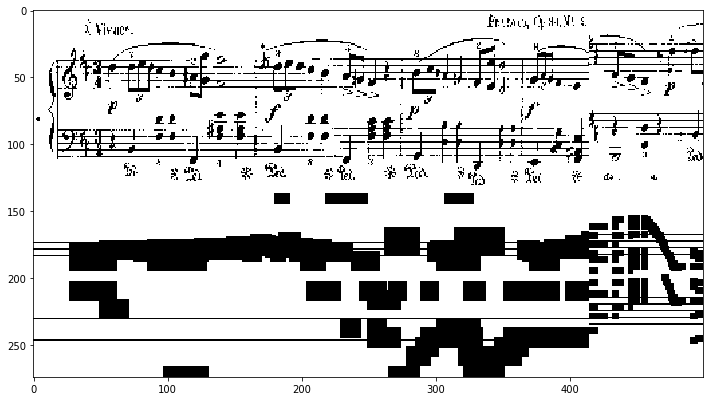

In [101]:
start = 0
end = start+500
showImage(stacked[:,start:end])
#plt.axis('off')
#plt.savefig('figs/exampleCorrect.png', dpi=300, bbox_inches = 'tight') # op68no3_v2, pid1263b-19-avgtapsd0.mid
#plt.savefig('figs/exampleWrong.png', dpi=300, bbox_inches = 'tight') # op30no2_v4, pid9073-21-avgtapsd0.mid

### Align all midi-sheet pairs

In [102]:
pieces = ['op30no2', 'op63no3', 'op68no3', 'Beethoven_sonata27_Op90_Clean_Movement1']
hyp_dir = 'hyp_align'
os.mkdir(hyp_dir)
zeroPad = 50

for piece in pieces:  # for every pair of matching scores
    scores = [os.path.basename(elem) for elem in sorted(glob.glob('score_data/prepped_png/%s_v*' % piece))]
    midifiles = [m for m in sorted(glob.glob('midi/%s/*.mid' % piece))]
    for score in scores:
        strips = loadStripData(score)
        striplens = [s.shape[1] for s in strips]
        for i, midifile in enumerate(midifiles):
            wp, midiSynths, timeMapping, fs = alignStripSequence(strips, midifile, zeroPad)
            midiID = os.path.splitext(os.path.basename(midifile))[0]
            outfile = '%s/%s--%s.pkl' % (hyp_dir, score, midiID)
            with open(outfile,'wb') as f:
                pickle.dump({'wp':wp,'striplens':striplens,'fs':fs,'zeroPad':zeroPad,'timeMapping':timeMapping}, f)
            print('Processed %d of %d, %s' % (i+1, len(midifiles), score))

FileExistsError: [Errno 17] File exists: 'hyp_align'